Text processing 1
----------------------

In [1]:
# importations
import re
import spacy
import nltk
import pandas as pd
from typing import *
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# define a style for the matplotlib plots
plt.style.use("ggplot")

c:\Users\Oumar Kane\AppData\Local\pypoetry\Cache\virtualenvs\pytorch1-HleOW5am-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We obtained new paragraphs after matching the French paragraphs with their Wolof counterparts. It is time to make further processing of the text. Notably, we want to process the text as follows:

1. Load, print each corpus, and identify additional corrections to add to the text;

2. Identify the length of each paragraph in each corpus and compare them;

3. Identify the longest and shortest paragraphs;

4. Modify the pre-created nlp pipeline class for that project; 

5. Identify the options to add to `spacy` (if it is used) to find the tokens;

6. Use the pre-created nlp pipeline class to recuperate the tokens;

7. Identify the nlp pipeline sub-steps.

### Add additional corrections to the text

It is possible that we forgot to add some corrections to the texts. Let us load the data frame and print the paragraphs in order to see what corrections will be necessary before diving deeper into the text processing.

In [2]:
# Load the data frame and make a copy
corpora_v1 = pd.read_csv("data/extractions/new_data/corpora_v1.csv", encoding='utf-16')

corpora = corpora_v1.copy()

In [3]:
# print the head
corpora.head()

,french_corpus,wolof_corpus
0,Tout être humain est le résultat d’un père et ...,"Doomu-aadama bu, ne ci ndey ak baay nga jóge. ..."
1,J’ai longtemps rêvé que ma mère était noire. J...,"Bi ma delloo dëkk ba ma juddoo, dama faa meloo..."
2,"De ce visage que j’ai reçu à ma naissance, j’a...","Kanam gii ma judduwaale, am na lu bari lu ma c..."
3,"À l’âge de huit ans à peu près, j’ai vécu en A...",Daanaka bi ma tolloo ci juróom-ňetti at laa to...
4,"De ce temps, pour ainsi dire consécutivement, ...","Ay yarami nit di ma feeňu, nag. Sama yaram, sa..."


Let us display more clearly the corpora by printing the dictionary version of it.

In [4]:
corpora_dict = corpora.to_dict(orient='index')

corpora_dict

{0: {'french_corpus': 'Tout être humain est le résultat d’un père et une mère. On peut ne pas les reconnaître, ne pas les aimer, on peut douter d’eux. Mais ils sont là, avec leur visage, leurs attitudes, leurs manières et leurs manies, leurs illusions, leurs espoirs, la forme de leurs mains et de leurs doigts de pied, la couleur de leurs yeux et de leurs cheveux, leur façon de parler, leurs pensées, probablement l’âge de leur mort, tout cela est passé en nous.',
  'wolof_corpus': 'Doomu-aadama bu, ne ci ndey ak baay nga jóge. Mënunu leen a baň a gërëm ak a bëgg, doonte sax mën nanoo am xel ňaar ci ňoom. Waaye ňu ngi fi, ak seen xar-kanam, seen taxawaay, seen defin ak seen jikko, seeni njuumte, seeni yaakaar, seen melokaanu loxook baaraami tànk, seen meloy bët ak karaw, seen waxin, seeni xalaat, amaana sax at ma ňuy nar a génne àddina. Loolu lépp, day àgg fu sore ci nun.'},
 1: {'french_corpus': 'J’ai longtemps rêvé que ma mère était noire. Je m’étais inventé une histoire, un passé, pou

We identified some elements seeming to not be very interesting in some cases:

- The en dash "–" is used in the French and Wolof corpus but not in the same places in two paragraphs with identical syntaxes. In some French sentences, we can see the use of the en dash but not in the Wolof version of that sentence and vice versa. The en dash carries some sense in the narration, essential for the translations. And since we have an actual occurrence of the "–" sign in the corpora, we cannot identify all their non-interesting.

- The abbreviation of the "ème" to "e." In English, it is used to identify ordinal numbers. The problem is that the two cases we use are not taken back in their Wolof version since the Wolof doesn't contain a translation of them. We can suppose that no attention will be added to them, but we can also delete them. When we want to translate a Wolof sentence to a French sentence, the ordinal numbers can be confused with a cardinal number or vice versa. 

- The identified numbers (non-nominal ones) in the corpora can be either years or ordinal numbers or the "6x6" element. Only the years seam to appear in both the french and the Wolof corpora. The other numbers could be more irrelevant in the context. Since more French numbers are nominally translated to the Wolof with letters, writing the number to letters is more useful before translating them.

- Some paragraphs should be shorter and can contain more than one context. It will be more beneficial to identify the paragraph containing multiple contexts and separate them into various elements or to concatenate two consecutive paragraphs with the same context. It will be simpler for the large language model to identify the context of a given paragraph. But we will do so if we find that the training needs to be more accurate. It will also permit us to obtain more paragraphs since we only have 141 paragraphs which is a small number (but with a down-streaming approach, it will be OK). If the downstream don't solve the problem of the lack of data we will generate new data with the `GAN (Generative Adversarial Network)` approach.

- The text contains some additional spaces that we will delete later, but we didn't find stacked words in the corpora.

- Like we said in the previous processing steps, some sentences in the Wolof paragraphs are reversed compared to their French counterparts. But since they are in the same context, we can use them like they are.

- Some words can be in one corpus and not translated into another which will sometime add a bias to the translation!! 

### Count the number of letters and words

The first comparison made between the two corpora is between their lengths:

- First, we will define a length of a document to be the number of her letters
- Second, we will define a length of document to be the number of her words (separated by spaces only). 

Let us consider the two different types of lengths and show their distributions over the documents.

In [5]:
# length as number letters (space in count)
count_letters = lambda doc_: len(doc_)

corpora['french_corpus_n_letters'] = corpora['french_corpus'].map(count_letters)

corpora['wolof_corpus_n_letters'] = corpora['wolof_corpus'].map(count_letters)

# length as number of words
count_words_space = lambda doc_: len(doc_.split())

corpora['french_corpus_n_words'] = corpora['french_corpus'].map(count_words_space)

corpora['wolof_corpus_n_words'] = corpora['wolof_corpus'].map(count_words_space)


In [6]:
# print the first documents
corpora.head()

,french_corpus,wolof_corpus,french_corpus_n_letters,wolof_corpus_n_letters,french_corpus_n_words,wolof_corpus_n_words
0,Tout être humain est le résultat d’un père et ...,"Doomu-aadama bu, ne ci ndey ak baay nga jóge. ...",441,396,80,76
1,J’ai longtemps rêvé que ma mère était noire. J...,"Bi ma delloo dëkk ba ma juddoo, dama faa meloo...",506,570,86,115
2,"De ce visage que j’ai reçu à ma naissance, j’a...","Kanam gii ma judduwaale, am na lu bari lu ma c...",448,500,79,108
3,"À l’âge de huit ans à peu près, j’ai vécu en A...",Daanaka bi ma tolloo ci juróom-ňetti at laa to...,1191,960,212,181
4,"De ce temps, pour ainsi dire consécutivement, ...","Ay yarami nit di ma feeňu, nag. Sama yaram, sa...",922,794,161,165


Let us trace the distributions of the number of letters and the distributions of the numbers words separated by spaces.

In [7]:
def plot_lengths(data_frame: pd.DataFrame, columns_regex: List = [".*n_letters", ".*n_words"]):
    
    fig = make_subplots(rows=len(columns_regex), cols=1, subplot_titles=columns_regex, y_title="Numbers", x_title="documents")
    
    for i, column in enumerate(columns_regex):
        
        columns = [column_ for column_ in data_frame.columns if re.search(column, column_)]
        
        for col_ in columns:
            
            # fig.add_trace(go.Histogram(
            #     x = data_frame[col_], name=col_
            # ), row=i+1, col=1)
            
            fig.add_trace(go.Scatter(
                y = data_frame[col_], name=col_
            ), row=i+1, col=1)
    
    fig.show()

plot_lengths(corpora)    

On the top of the figure we consider the distributions of the number of letters: the blue line indicates the distribution traced over the french corpus and the red line that traced over the wolof corpus.

On the bottom of the figure we consider the distributions of the number of words: the violet line indicates the distribution traced over the french corpus and the green line that traced over the wolof corpus.

We have the same distribution tendency both for the number of letters and for the number of words. Which is what we expected to find.

### Identify the shortest and the longest paragraphs

Identifying the longest and the shortest paragraphs will help us identify paragraphs with abnormal lengths and constitution. Let us display the 5 shortest and longest paragraphs. 

Let us consider, first, the length to be the number of letters.

In [8]:
# let us sort the corpora by number of letters 
sorted_corpora_french1 = corpora.sort_values(by="french_corpus_n_letters")[['french_corpus', 'french_corpus_n_letters']]

sorted_corpora_wolof1 = corpora.sort_values(by="wolof_corpus_n_letters")[['wolof_corpus', 'wolof_corpus_n_letters']]

# let us recuperate the top 10s
top_french_corpora = sorted_corpora_french1.head()

top_wolof_corpora = sorted_corpora_wolof1.head()

# let us recuperate the bottom 10s
bot_french_corpora = sorted_corpora_french1.tail()

bot_wolof_corpora = sorted_corpora_wolof1.tail()


Display the ten first paragraphs.


In [9]:
top_french_corpora

,french_corpus,french_corpus_n_letters
24,Nous savions que c’était la ville des termites.,47
103,"Comment vit-il ces longues années de guerre, s...",138
137,Si je n’avais pas eu cette connaissance charne...,152
135,Mais je me souviens de tout ce que j’ai reçu q...,195
120,Tout cela peut sembler anecdotique. Mais ces m...,207


In [10]:
top_wolof_corpora

,wolof_corpus,wolof_corpus_n_letters
24,"Nu daldi xoolante, xam ni yegsi nanu ci dëkku ...",53
103,Naka la tooge woon moom kott ci kër googu juró...,102
137,"Waaw, su Afrig duggul woon ba ci samay biir ya...",103
120,"Lii lépp, mën naa niiruy waxi kasaw-kasaw. Moo...",129
59,"Li ëpp ci nataal yi Baay jël, dañuy wone xolub...",206


The shortest paragraph in the french corpus has 47 letters in it and the one in the wolof corpus has 53 letters in it. They contain both of them a normal length. 

Let us display ten last paragraphs.

In [11]:
bot_french_corpora

,french_corpus,french_corpus_n_letters
64,"C’est ce même voyage que j’ai fait, vingt ans ...",2228
65,"Tout cela, je ne l’ai compris que beaucoup plu...",2257
7,"L’entrée dans Obudu, je m’en souviens bien : l...",2257
13,L’Afrique était puissante. Pour l’enfant que j...,2717
126,"En 1968, tandis que mon père et ma mère regard...",3350


In [12]:
bot_wolof_corpora

,wolof_corpus,wolof_corpus_n_letters
67,"Ku laajoon Baay fan la Afrig tàmbalee ci moom,...",2131
81,Su weesoo dénd wi làrme réewum Almaañ defar ci...,2170
64,"Xare bi jeex, ñu tekk ci ñaar-fukki at, ma ànd...",2279
111,Nit ki ma teerusi ci waaxu Poor-Arkuur dafa me...,2357
126,"Atum 1968 agsi, di at mu bariy yëngu-yëngu. Ma...",2867


Since the longest paragraphs have not a abnormal number of letters compared with those preceding them we cannot say that they are abnormal. But let's trace the box plot of the length to verify our hypotheses.

In [13]:
px.box(data_frame=corpora, x = ["french_corpus_n_letters", "wolof_corpus_n_letters"])

For the `wolof_corpus_n_letters` we identify a upper fence of **2170** letters and 3 paragraphs are then considered to be abnormals. For the `french_corpus_n_letters` we identify a upper fence of **2282** letters and 2 paragraphs are considered to be abnormals. Let us recuperated those documents.

In [14]:
french_abnormal_n_letters = corpora[corpora["french_corpus_n_letters"] > 2282]["french_corpus"]
wolof_abnormal_n_letters = corpora[corpora["wolof_corpus_n_letters"] > 2170]["wolof_corpus"]

# print those "abnormal" paragraphs
french_abnormal_n_letters.to_list(), wolof_abnormal_n_letters.to_list()

(['L’Afrique était puissante. Pour l’enfant que j’étais, la violence était générale, indiscutable. Elle donnait de l’enthousiasme. Il est difficile d’en parler aujourd’hui, après tant de catastrophes et d’abandon. Peu d’Européens ont connu ce sentiment. Le travail que faisait mon père au Cameroun d’abord, puis au Nigeria, créait une situation exceptionnelle. La plupart des Anglais en poste dans la colonie exerçaient des fonctions administratives. Ils étaient militaires, juges, district officers (ces D.O. dont les initiales, prononcées à l’anglaise, Di-O, m’avaient fait penser à un nom religieux, comme une variation sur le « Deo gratias » de la messe que ma mère célébrait sous la varangue chaque dimanche matin). Mon père était l’unique médecin dans un rayon de soixante kilomètres. Mais cette dimension que je donne n’a aucun sens : la première ville administrative était Abakaliki, à quatre heures de route, et pour y arriver il fallait traverser la rivière Aiya en bac, puis une épaisse fo

In [15]:
# print their indices
french_abnormal_n_letters.index, wolof_abnormal_n_letters.index


(Int64Index([13, 126], dtype='int64'),
 Int64Index([64, 111, 126], dtype='int64'))

Only the paragraph number 126 is considered to be abnormally long in the two corpora. 

Let are consider now the length to be the number of words separated by spaces. We will plot directly the box plot.

In [16]:
px.box(data_frame=corpora, x = ["french_corpus_n_words", "wolof_corpus_n_words"])


For the `wolof_corpus_n_words` we identify a upper fence of **447** letters and 2 paragraphs are then considered to be abnormals. For the `french_corpus_n_words` we identify a upper fence of **396** letters and 3 paragraphs are considered to be abnormals. Let us recuperated those documents.

In [17]:
french_abnormal_n_words = corpora[corpora["french_corpus_n_words"] > 396]["french_corpus"]
wolof_abnormal_n_words = corpora[corpora["wolof_corpus_n_words"] > 447]["wolof_corpus"]

# print those "abnormal" paragraphs
french_abnormal_n_words.to_list(), wolof_abnormal_n_words.to_list()

(['L’entrée dans Obudu, je m’en souviens bien : la route sort de l’ombre de la forêt et entre tout droit dans le village, en plein soleil. Mon père a arrêté son auto, avec ma mère il doit parler aux officiels. Je suis seul au milieu de la foule, je n’ai pas peur. Les mains me touchent, passent sur mes bras, sur mes cheveux autour du bord de mon chapeau. Parmi tous ceux qui se pressent autour de moi, il y a une vieille femme, enfin je ne sais pas qu’elle est vieille. Je suppose que c’est d’abord son âge que je remarque, parce qu’elle diffère des enfants nus et des hommes et des femmes habillés plus ou moins à l’occidentale que je vois à Ogoja. Quand ma mère revient (peut-être vaguement inquiète de ce rassemblement), je lui montre cette femme : « Qu’est-ce qu’elle a ? Est-ce qu’elle est malade ?» Je me souviens de cette question que j’ai posée à ma mère. Le corps nu de cette femme, fait de plis, de rides, sa peau comme une outre dégonflée, ses seins allongés et flasques, pendant sur son 

In [18]:
# print their indices
french_abnormal_n_words.index, wolof_abnormal_n_words.index

(Int64Index([7, 13, 126], dtype='int64'),
 Int64Index([111, 126], dtype='int64'))

The paragraph 126 is again the only paragraph to be considered as "abnormally" long in the two corpora.

**Conclusion 1**: The paragraph number **126** seem to be the longest paragraph in both the french and the wolof corpora. The paragraphs at indices **13** (in the french corpus) and **111** (in the wolof corpus) are considered to be abnormal for both of the two types of lengths. Only the paragraphs at indices **64** (in the wolof corpus) and **7** (in the french corpus) are spotted only once. But let us consider all of them to be "abnormally" long and try to separated them contextually (considering contexts). The purpose of the separation is to obtain a paragraph with her/their corresponding length(s) to be bellow the upper fence(s). 

---------------------------------

We will separate those paragraphs directly from copies of the csv files containing the paragraphs. The separation will be done by contexts and according to the following scheduling:

- For the paragraph 7: (length as number of words)
    - French corpus: 
        - "L'entrée dans Obudu..." (L'entrée dans Obudu) -> length = 69 
        - "Parmi tous ceux qui se pressent..." (Ma grand-mère) -> length = 340 
    - Wolof corpus:
        - "Sooy dugg Óbudu..."
        - "Ma seetlu ci mbooloo mi benn..."

- Paragraph 13: (length as number of words and number of letters)
    - French corpus:
        - "L’Afrique était puissante..." (L'Afrique était puissante) -> number_of_letters = 250, number_of_words = 34 
        - "Le travail que faisait mon père..." (Le travail que faisait mon pere) -> number_of_letters = 1130, number_of_words = 185 
        - "Nous étions, mon frère et moi..." (Les seuls blancs) -> number_of_letters = 1335, number_of_words = 230
    - Wolof corpus:
        - "Duma ko tàyyee wax..."
        - "Liggéey bi Baay daan def..."
        - "Maak sama mag ju..."

- Paragraph 64: (length as number of letters)
    - Wolof corpus:
        - "Xare bi jeex, ñu tekk ci..." (Rencontre avec mon pere en Afrique) -> number_of_letters = 334 
        - "Magam ji tuddoon Ësen..." (La difficulté en Afrique) -> number_of_letters = 1284
        - "Afrig, dafa fa dem ba jeex..." (La duree d'une vie en Afrique) -> number_of_letters = 659
    - French corpus:
        - "C’est ce même voyage..."
        - "Son frère Eugène, qui..."
        - "Dans l’Ouest africain..."

- Paragraph 111: (length as number of words and number of letters)
    - Wolof corpus: 
        - "Nit ki ma teerusi ci waaxu..." (Rencontre avec un homme d'un autre monde) -> number_of_letters = 766, number_of_words = 156
        - "Ci sama gis-gisu gone..." (Les rituels et manies de mon pere) -> number_of_letters = 1590, number_of_words = 327
    - French corpus:
        - "L’homme qui m’est apparu..."
        - "Il était plein de manies..."

- Paragraph 126: (length as number of words and number of letters)
    - French corpus:
        - "En 1968, tandis que mon père..." (Un des plus grand genocides du siecle) -> number_of_letters = 1492, number_of_words = 216
        - "Mais à la fin de l’été 1968..." (Situation du genocide en fin d'ete) -> number_of_letters = 965, number_of_words = 152
        - "À partir de septembre,..." (Fin du genocide) -> number_of_letters = 891, number_of_words = 144
    - Wolof corpus:
        - "Atum 1968 agsi, di..." -> number_of_letters = 1276, number_of_words = 238
        - "Waaye bi nawetu 1968..." -> number_of_letters = 792, number_of_words = 148
        - "Weeru sàttumbar agsi..." -> number_of_letters = 797, number_of_words = 156


    

----------------------------

Let us load the new paragraphs and save the new corpora.

In [19]:
french_version_v5 = pd.read_csv("data/extractions/new_data/french_version_v5.csv")

wolof_version_v5 = pd.read_csv("data/extractions/new_data/wolof_version_v5.csv")

french_version_v5.rename(columns={'0': "french_corpus"}, inplace=True)

wolof_version_v5.rename(columns={'0': "wolof_corpus"}, inplace=True)

In [20]:
# combine the paragraphs in a unique DataFrame
corpora_v2 = pd.concat((french_version_v5, wolof_version_v5), axis=1)

In [21]:
# save the corpora
corpora_v2.to_csv("data/extractions/new_data/corpora_v2.csv", index=False, encoding='utf-16')

Let us display the same plots as for the previous corpora.

In [22]:
# make a copy of the corpora
corpora = corpora_v2.copy()

- Length distributions

In [23]:
# length as number letters (space in count)
corpora['french_corpus_n_letters'] = corpora['french_corpus'].map(count_letters)

corpora['wolof_corpus_n_letters'] = corpora['wolof_corpus'].map(count_letters)

# length as number of words
corpora['french_corpus_n_words'] = corpora['french_corpus'].map(count_words_space)

corpora['wolof_corpus_n_words'] = corpora['wolof_corpus'].map(count_words_space)

plot_lengths(corpora)


We obtain again almost the same distributions. But the distributions over the number of words is more accurate for analyzes. So let us display only the box plot of the number of words.

- Box on number of words

In [24]:
px.box(data_frame=corpora, x = ["french_corpus_n_words", "wolof_corpus_n_words"])


Only one paragraph has a length greater than the upper fence of **376** words and only on the french corpus. The length of that paragraph is equal to the upper fence calculated over the length of the previous corpora. Let us verify what is that paragraph.

In [25]:
abnormal_n_words = corpora[corpora["french_corpus_n_words"] > 376]["french_corpus"]

abnormal_n_words

70    Tout cela, je ne l’ai compris que beaucoup plu...
Name: french_corpus, dtype: object

It correspond to the paragraph at index 70. We can verify if it contains multiple contexts.

The paragraph contains only one context so it will be complicated to split it. Let us consider that its length is on the limit of the previous corpora and can be then integrated in our analyzes as it is.

### Modify the pre-create natural language processing class 

We created a nlp pipeline class to process and analyze the kaggle tweet competition text data set. The notebook of that project is available at the following github link [kaggle_tweet_nlp](https://github.com/Oumar199/nlp_programs_exercises/blob/master/kaggle_tweet_competition_eda_preprocessing.ipynb). The difference in our project is that **we don't treat tweets which contains urls, html, emojis, etc** but **a normal text from a book** and also that **we don't have a target to predict** but **in that place two corpus in place of one**. **Each corpus will be processed differently** and the **discretized version of the tokens will represent the inputs of the model**. 

- Modify the tokenizer function 

    The tokenizer function use a spacy model to identify the tokens inside each document. A list of tokens is provided after processing on each of them. The function need some arguments in order to process correctly the documents. But some of them are not important in the current project and will be deleted. Another thing is to not take the lower case of the words and keep them as they are. We don't want to make an important number of processing on the tokens since we are making a translation task:
    - natural language processing object (created with spacy)
    - the corpus (a list of documents)
    - boolean arguments specifying if we want to:
        - ~~remove the stopwords~~: The stopwords are a part of the text
        - ~~remove the non ascii terms~~: We will keep non ascii terms if they are present in the text 
        - ~~collect only alphanumerical tokens~~: Non alphanumerical tokens like parentheses will be important for the translation
        - ~~delete the punctuations~~: The punctuations are a part of the text 
        - trim the spaces
        - ~~keep urls~~: The text doesn't contain urls
        - ~~keep html expression~~: The text doesn't contain html expression
        - ~~keep emojis~~: The text doesn't contain emojis
        - ~~keep mentions~~: The text doesn't contain camel cased tokens
        - ~~keep upper cased words~~: All upper cased or capitalized words are important for the translation.
        - ~~lem the tokens~~: No lemmatization is required 
    - ~~the minimum length of a token (to delete the emojis)~~: If minimum is added punctuations will be deleted
    - ~~the maximum length of a token~~: All words with multiple letters are important
    - ~~list of entity types to delete~~: We cannot identify all of the entities and we will maybe need to process them manually (after their identification)
    - ~~list of pos tags to keep (if not specified we can keep all of the pos tags)~~: We cannot identify all of them (particularly in the wolof corpus)

    The main purpose of the modification is to keep most tokens as possible.

In [29]:
%%writefile wolof-translate/wolof_translate/utils/tokenize_text.py

import spacy
from typing import *

def tokenization(nlp = spacy.load("fr_core_news_lg"), 
                 corpus: Union[List[str], Tuple[str]] = [],
                 rm_spaces: bool = True,
                 ):
    """Tokenize the text (keep each of the unique token both in the french and the wolof corpora)

    Args:
        nlp (_type_, optional): A spacy model. Defaults to spacy.load("fr_core_news_lg").
        corpus (Union[List[str], Tuple[str]], optional): The list of documents. Defaults to [].
        rm_spaces (bool, optional): Indicate if the too much spaces will be deleted. Defaults to True.

    Returns:
        List[List[str]]: The list of list of tokens
    """
    
    # Create a inner function to tokenize a given document
    def transformation(doc):
        
        tokens = []
        
        for token in doc:
            
            if not (rm_spaces and token.is_space):
               
               tokens.append(token.text)
               
        return tokens
                
    # Let's create a pipeline with the nlp object
    docs = nlp.pipe(corpus)
    
    # Initialize the list of tokenized documents and the list of pos_tags
    tokens = []
    
    for doc in docs:
        
        tokens_ = transformation(doc)
    
        tokens.append(tokens_)
        
    return tokens 

Overwriting wolof-translate/wolof_translate/utils/tokenize_text.py


In [30]:
%run wolof-translate/wolof_translate/utils/tokenize_text.py

- Modify the nlp pipeline class
    We created the nlp pipeline class in order to manipulate a data frame containing a corpus and the target of each document in the corpus. In our case we want to provide only the corpus and we don't need a target column since we are making translation over two corpora. Only one corpus will be provided at a time to the class but we can also transfer the pipeline to other corpora. The tokenization method step will be adapted for the previous tokenization function. The pipeline of the class were composed of the following steps:
    - tokenize_text ⚡
    - create_corpus: That corpus is different of the provided corpus
    - create_frequency
    - show_frequency_out_limits
    - show_most_common_words
    - plot_frequency_histogram
    - show_n_time_frequency_words
    - delete_n_time_frequency_words
    - ~~stem words (if no lemming)~~
    - ~~corpus_filter~~
    - ~~get_words_w_same_targets~~
    - remove_words
    - ~~remove_words_w_same_targets~~
    - recuperate_results ⚡
    - ~~add_results_to_data_frame~~
    - add_results_to_corpus 🕯️
    - plot_wordcloud
    - create_n_grams
    - set_n_grams_as_corpus
    - ...
    - reset_corpus
    - predict_next_word

    The strikethrough steps are those that we will not add in our pipeline. The step with the flash emoji in their front are the modified steps. The one with a candle in front of it is a new method.

In [31]:
# !pip install -e wolof-translate --quiet

In [32]:
%%writefile wolof-translate/wolof_translate/pipe/nlp_pipeline.py

from wolof_translate.utils import tokenization
from nlp_project.processing.utils import get_n_grams, guess_limitations, wordcloud
from nlp_project import *
    

class TextPipeProcessing:
    """The pipeline is composed by (* if obligatory processing):
    - tokenize_text*
    - create_corpus*
    - create_n_grams
    - set_n_grams_as_corpus
    - reset_corpus
    - create_frequency*
    - show_frequency_out_limits
    - show_most_common_words
    - plot_frequency_histogram
    - show_n_time_frequency_words
    - delete_n_time_frequency_words
    - remove_words
    - recuperate_results*
    - add_results_to_corpus*
    - plot_wordcloud
    - some other issues...
    - use context manager to store a pipeline
    """
    pipeline = {}
    
    def __init__(self, corpus: List[str], name: str = "nlp_pipeline"):
        """Initialize main attributes

        Args:
            corpus (list): The list of documents. 
            name (str): The name of the pipeline
        """
        
        self.corpus = corpus
        
        self._corpus = None
        
        self._n_grams = None
        
        self._old_corpus = None
        
        self._grams_active = False
        
        self.bigrams = None
        
        self.trigrams = None
        
        self.name = name

    def __enter__(self):
        
        self.current_pipe = []
        
        return self
    
    def __call__(self, method: Callable, get_results: bool = True, *args, **kwargs):
    
        self.current_pipe.append({"method": method, "args": args, "kwargs": kwargs, "result": get_results})
    
    def tokenize_text(self,
                      nlp, 
                      rm_spaces: bool = True
                      ):
        """Tokenizing the text

        Args:
            nlp (_type_): The spacy model to use
            rm_spaces (bool, optional): Indicates if we want to remove the spaces. Defaults to True.

        Returns:
            List[List[str]]: List of tokens
        """
        self._nlp = nlp
        
        self._tokenizer = lambda texts: tokenization(
                      nlp,
                      texts,
                      rm_spaces
                    )
        
        self._tokens = self._tokenizer(self.corpus)
    
        return self._tokens
    
    def create_corpus(self):
        """Creating a list containing all the non distinct tokens 

        Returns:
            Tuple[list, nltk.Text]: The list of non distinct tokens and the nltk text composed of the tokens
        """
        self._corpus = []
        
        for document in tqdm(self._tokens):
            
            self._corpus.extend(document)
        
        self._corpus_text = nltk.text.Text(self._corpus)
        
        print(f"Number of words: {len(self._corpus):->16}")
        print(f"Number of unique words: {len(self._corpus_text.vocab()):->16}")
        
        return self._corpus, self._corpus_text
    
    def create_n_grams(self, n: int = 2):
        """Create n grams

        Args:
            n (int, optional): The length of a gram. Defaults to 2.

        Returns:
            Tuple[list, nltk.Text]: A list of n grams and the nltk text format of the n grams
        """
        assert n >= 2
        
        self._n_grams = []
        
        for document in tqdm(self._tokens):
            
            n_gram = get_n_grams(document, n)
            
            self._n_grams.extend(n_gram)
        
        self._n_grams_text = nltk.text.Text(self._n_grams)
        
        print(f"Number of {n} grams: {len(self._n_grams):->16}")
        print(f"Number of unique {n} grams: {len(self._n_grams_text.vocab()):->16}")

        return self._n_grams, self._n_grams_text
        
    def set_n_grams_as_corpus(self):
        """Set the n grams as the list of tokens

        Raises:
            AttributeError: The create_n_grams is not called!
        """
        self._old_corpus = self._corpus
        
        self._old_corpus_text = self._corpus_text
        
        if not self._n_grams:
            
            raise AttributeError("You didn't create the n grams with the `create_n_grams` method!")
        
        self._corpus = self._n_grams
        
        self._corpus_text = self._n_grams_text
        
        self._grams_active = True

    def reset_corpus(self):
        """Recuperating the initial corpus

        Raises:
            AttributeError: The corpus is not yet created
        """
        if not self._old_corpus:
            
            raise AttributeError("The corpus was not properly created. To create a new corpus from tokens use the `create_corpus` method!")
        
        self._corpus = self._old_corpus
        
        self._corpus_text = self._old_corpus_text
        
        self._grams_active = False
    
    def create_frequency(self):
        """Create tokens' frequencies from the list of tokens 
        """
        self._frequency = pd.DataFrame.from_dict(self._corpus_text.vocab(), 'index')
        
        self._frequency.rename({0: 'frequency'}, inplace=True, axis=1)
        
        self._frequency.reset_index(level=0, inplace=True)
        
        print(self._frequency.head())
    
    def show_frequency_out_limits(self):
        """Print the frequencies fences
        """
        px.box(data_frame=self._frequency, x="frequency", hover_data=['index', 'frequency']) 
        
        self.low, self.high = guess_limitations(self._frequency, 'frequency') 
        
        print(f"Low limit: {self.low:->16}")
        print(f"High limit: {self.high:->16}")
    
    def show_most_common_words(self, lower_bound: int = 400, n_words: int = 20):
        """Print the most common tokens (can be n grams)

        Args:
            lower_bound (int, optional): The lower bound of the frequencies. Defaults to 400.
            n_words (int, optional): The number of tokens to display. Defaults to 20.
        """
        self._freq_total = nltk.Counter(self._corpus_text.vocab())
        
        self._stopwords_common = list(zip(*self._freq_total.most_common(lower_bound)))[0]
        
        print("Most common words are:")
        print(self._stopwords_common[:20])
    
    def plot_frequency_histogram(self, bottom: int = 8):
        """Plot the histogram of the frequencies

        Args:
            bottom (int, optional): The number of the sorted frequencies to display their histograms. Defaults to 8.
        """
        f_values = self._frequency['frequency'].sort_values().unique()        
    
        bottom_ = self._frequency[self._frequency['frequency'].isin(f_values[:bottom])]
        
        fig = px.histogram(data_frame = bottom_, x = 'frequency', title=f"Frequency histogram for {bottom} frequency on the bottom")
        
        fig.show()
        
    def show_n_time_frequency_words(self, n_time_freq: Union[int, list] = 1, n_words: int = 100):
        """Print the percentage of tokens appearing the specified number of times (frequency) in the corpus

        Args:
            n_time_freq (Union[int, list], optional): The frequency. Defaults to 1.
            n_words (int, optional): The number of words to display. Defaults to 100.
        """
        n_time_freq = [n_time_freq] if type(n_time_freq) is int else n_time_freq
        
        size = self._frequency[self._frequency['frequency'].isin(n_time_freq)].shape[0]
        
        n_time_frequency = self._frequency[self._frequency['frequency'].isin(n_time_freq)]
        
        print(f"Percentage of words appearing {'/'.join([str(freq) for freq in n_time_freq])} times in the dataset: {size / self._frequency.shape[0]}%")
        
        print(f"Words appearing {'/'.join([str(freq) for freq in n_time_freq])} times:")
        print(n_time_frequency.iloc[:n_words,:])
    
    def delete_n_time_frequency_words(self, n_time_freq: Union[int, list] = 1):
        """Delete the tokens appearing a specified number of times in the corpus

        Args:
            n_time_freq (Union[int, list], optional): The number of times that that tokens appears. Defaults to 1.
        """
        n_time_freq = [n_time_freq] if type(n_time_freq) is int else n_time_freq
        
        n_time_frequency = self._frequency[self._frequency['frequency'].isin(n_time_freq)]
        
        self._new_frequency = self._frequency.loc[~self._frequency['index'].isin(n_time_frequency['index'].to_list()), :]
        
        print("The new frequency data frame is stored in `_new_frequency` attribute.")
        
        print(f"The number of deleted observations: {n_time_frequency.shape[0]:->16}")
        
    def remove_words(self, words_to_remove: List[str]):
        """Remove tokens from the corpus

        Args:
            words_to_remove (List[str]): List of tokens to remove
        """
        self._new_frequency = self._new_frequency.copy()
        
        self._new_frequency.drop(index=self._new_frequency[self._new_frequency['index'].isin(words_to_remove)].index, inplace = True)
    
    def recuperate_results(self):
        """Recuperate the results as a dictionary of the tokens with their frequencies as values

        Returns:
            Tuple[nltk.FreqDist, List[tuple]]: A tuple containing the frequencies and a list of the tokens with their distinct positions in the dictionary
        """
        try:
            frequency = self._new_frequency.copy()
        except:
            frequency = self._frequency.copy()
        finally:
            print("The recuperate results method recuperates the last version of the frequency data frame as a freqDist. Make sure to add transformations before calling this method!")
        
        frequency.set_index('index', inplace = True)
        
        frequency = frequency.to_dict()
        
        frequency = frequency['frequency']
        
        self._results = nltk.FreqDist(frequency)
        
        if self._grams_active:
            
            keys = list(self._results.keys())
            
            if len(keys[0].split(" ")) == 2:
                
                self._bigrams = self._results
            
            elif len(keys[0].split(" ")) == 3:
                
                self._trigrams = self._results
        
        self._positions = {i: list(self._results.keys())[i] for i in range(len(self._results))} # positions of tokens begin at 0
        
        return self._results, self._positions
    
    def add_results_to_corpus(self):
        """Add final tokens to the corpus

        Raises:
            ValueError: Only uni grams can be added
        """
        if self._grams_active:
                
                print("You didn't reset the corpus with the `reset_corpus` method!")
        
        def clean_text(tokens: list, words: Union[nltk.FreqDist, list, set, tuple] = self._results):
            """Clean a given document by taking only words that are chosen as representative of the target

            Args:
                tokens (int): The tokens of the document
                words (Union[nltk.FreqDist, dict, list, set, tuple]): The words that we want to preserve

            Returns:
                str: The new document
            """
            
            if len(list(words.keys())[0].split(" ")) != 1:
                
                raise ValueError("Only uni grams can be provide as results to the data frame text column!")

            tokens_ = [tokens[0]]
            
            for i in range(1, len(tokens)):
                
                if tokens[i] == "-" and tokens_[-1] != "-" or tokens_[-1][-1] == "-":
                    
                    tokens_[-1] = tokens_[-1] + tokens[i] 
                
            [token for token in tokens if token in words]
            
            return " ".join(tokens_)
        
        self.corpus = list(map(clean_text), self._tokens)
        
    def plot_wordcloud(self, figsize: tuple = (8, 8), max_font_size: int = 60, max_words: int = 100, background_color = "white"):
        """Plot a wordcloud of the corpus

        Args:
            figsize (tuple, optional): The figure size with width and height. Defaults to (8, 8).
            max_font_size (int, optional): The maximum size of the font. Defaults to 60.
            max_words (int, optional): The maximum number of words on top of frequencies. Defaults to 100.
            background_color (str, optional): The background color. Defaults to "white"
        """
      
        wordcloud(" ".join(self.corpus), figsize=figsize, max_font_size=max_font_size, max_words=max_words)
            
    def predict_next_word(self, text: str):

            if self._bigrams and self._trigrams:
                
                bigram = " ".join(text.split(" ")[-2:])
                
                co_occs = []
                
                trigrams = []
                
                for trigram in self._trigrams:
                    
                    if bigram in trigram[:len(bigram)]:
                        
                        if text in set(self._bigrams.keys()):
                            
                            freq1 = self._bigrams[bigram]
                            
                            freq2 = self._trigrams[trigram]
                            
                            co_occs.append(freq2 / freq1)
                            
                            trigrams.append(trigram)

                        else:
                
                            raise KeyError(f"The bigram {text} is not identified in the registered bigrams!")
                
                try:
                
                    max_co_occ = np.array([co_occs]).argmax()
                    
                    max_trigram = trigrams[max_co_occ]
                
                    return max_trigram.split(" ")[-1], co_occs[max_co_occ]
                
                except ValueError:
                    
                    return "", None
            
            else:
                
                raise ValueError("You must create bigrams and trigrams before using them to predict the next word of your text!")
    
    def display(self, text: str, style = "dep"):
        
        # Create a container object
        doc = self._nlp(text)
        
        # Render frame with displacy
        spacy.displacy.render(doc, style=style)
    
    def execute_pipeline(self, name: str = "nlp_pipeline"):
        """Execute the pipeline

        Args:
            name (str, optional): The name of the pipeline. Defaults to "nlp_pipeline".

        Raises:
            ValueError: The pipeline name must exist before being recuperated

        Returns:
            list: The list of results
        """
        
        results = []
        
        try:
        
            pipeline = self.pipeline[name]
            
            i = 1
            
            for pipe in pipeline:
                
                args = pipe['args']
                
                kwargs = pipe['kwargs']
                
                method = pipe['method']
                
                result = pipe['result']
                
                result_ = "True" if result else "False"
                
                print(f"Method {i}: {method.__name__} -> result = {result_}\n")
                
                results_ = method(*args, **kwargs)
                
                print("\n")
                
                print("#"*100)
                
                print("\n")
                
                i += 1
                
                if result:
                    
                    results.append(results_)
            
            return results
        
        except KeyError:
            
            raise ValueError("The pipeline that you specified doesn't exist!")
    
    def __exit__(self, ctx_ept, ctx_value, ctx_tb):
        
        self.pipeline[self.name] = self.current_pipe
        
        print("You can execute the pipeline with the `pipeline_name.execute_pipeline`! The pipelines are available in the attribute `pipeline`.")
        
        return ctx_value 



Overwriting wolof-translate/wolof_translate/pipe/nlp_pipeline.py


Let us import bellow the nlp pipeline class.

In [33]:
%run wolof-translate/wolof_translate/pipe/nlp_pipeline.py

### Identify supplementary options for spacy tokenization

The Wolof corpus contains suffixes like the following: `'a(a)', 'i(i)', 'u(u)', 'o(o)', 'e(e)', 'al(e)', 'aleek', 'alee', 'ant(e)', 'y', 'iy', 'ay', 'oy', 'am', 'ul', 'ati', '(a)di', 'an', '(w)aan', '(w)oon'`. It also contains prefixes, but suffixes could be more productive. 

However, the suffixes cannot all be identified since some words finish with them but are not concerned (all of them must be identified, which can take a long time since the book doesn't have all the words). Another thing is that we must create grammar rules to recompose the words after translation. So we take the tokens to their original form (without specifying suffixes and infixes).

The same thing is observed in the French languages or corpus but will require a more complicated task than specifying the suffixes and the prefixes (which can be productive in French) for the tokenization. Lemming or stemming the tokens will remove their suffixes or the text semantics. 

**Conclusion**: We will not separate the text to simplify the task and keep the `text semantic/contexts`, which is very important to make machine translation. 

### Tokenization

Let us specify the pipeline for the tokenization:

- tokenize_text: Delete all tokens with space only and recuperate the list of the list of tokens for each document
- create_corpus: Stacked the tokens in one list to obtain the tokens of the corpus and recuperate it
- create_frequency: Determine the frequency of the tokens 
- show_frequency_out_limits: Show the lower and upper fences of the frequencies
- show_most_common_words: Show most common words
- plot_frequency_histogram: Plot frequency histogram
- show_n_time_frequency_words (?)
- delete_n_time_frequency_words (?)
- remove_words (?)
- recuperate_results: Recuperate the results (tokens with frequencies and token indices)
- add_results_to_corpus (?)
- plot_wordcloud: Plot the Word Cloud of the corpus


The steps with no interrogation marks are the obligatory steps. Another step can be avoided if necessary. Let us begin with the French corpus and add the same pipeline to the Wolof corpus. 

We will use the large french model of spacy for the tokenization.

In [34]:
nlp = spacy.load('fr_core_news_lg')

- French corpus

In [35]:
with TextPipeProcessing(corpora['french_corpus'].to_list()) as pipeline1:
    
    # tokenize the text 
    pipeline1(pipeline1.tokenize_text, nlp = nlp)
    
    # create the corpus
    pipeline1(pipeline1.create_corpus)
    
    # create the frequency data frame
    pipeline1(pipeline1.create_frequency, False)
    
    # show frequency fences
    pipeline1(pipeline1.show_frequency_out_limits, False)
    
    # show most common words
    pipeline1(pipeline1.show_most_common_words, False)
    
    # plot frequency histogram
    pipeline1(pipeline1.plot_frequency_histogram, False)
    
    # recuperate the results
    pipeline1(pipeline1.recuperate_results)
    
    # plot the word cloud
    pipeline1(pipeline1.plot_wordcloud, False, figsize = (18, 7))

You can execute the pipeline with the `pipeline_name.execute_pipeline`! The pipelines are available in the attribute `pipeline`.


**Remark**: We got only the outputs from the tokenization, the corpus creation and the final results.

Let us verify the pipeline content. The current is named as "nlp_pipeline".

In [36]:
pipeline1.pipeline['nlp_pipeline']

[{'method': <bound method TextPipeProcessing.tokenize_text of <__main__.TextPipeProcessing object at 0x000001B06FB48760>>,
  'args': (),
  'kwargs': {'nlp': <spacy.lang.fr.French at 0x1afad80efb0>},
  'result': True},
 {'method': <bound method TextPipeProcessing.create_corpus of <__main__.TextPipeProcessing object at 0x000001B06FB48760>>,
  'args': (),
  'kwargs': {},
  'result': True},
 {'method': <bound method TextPipeProcessing.create_frequency of <__main__.TextPipeProcessing object at 0x000001B06FB48760>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.show_frequency_out_limits of <__main__.TextPipeProcessing object at 0x000001B06FB48760>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.show_most_common_words of <__main__.TextPipeProcessing object at 0x000001B06FB48760>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.plot_frequency_histogr

Let us execute the pipeline and investigate the results.

Method 1: tokenize_text -> result = True



####################################################################################################


Method 2: create_corpus -> result = True



100%|██████████| 149/149 [00:00<?, ?it/s]

Number of words: -----------27906
Number of unique words: ------------5099


####################################################################################################


Method 3: create_frequency -> result = False

    index  frequency
0    Tout         12
1    être         52
2  humain          2
3     est        197
4      le        383


####################################################################################################


Method 4: show_frequency_out_limits -> result = False

Low limit: -------------0.5
High limit: -------------3.5


####################################################################################################


Method 5: show_most_common_words -> result = False

Most common words are:
(',', 'de', '.', 'la', 'les', 'à', 'et', 'l’', 'des', 'le', 'd’', 'un', 'dans', 'en', 'qui', 'il', 'que', 'du', 'une', 'est')


####################################################################################################


Method 6: plot_frequ



####################################################################################################


Method 7: recuperate_results -> result = True

The recuperate results method recuperates the last version of the frequency data frame as a freqDist. Make sure to add transformations before calling this method!


####################################################################################################


Method 8: plot_wordcloud -> result = False



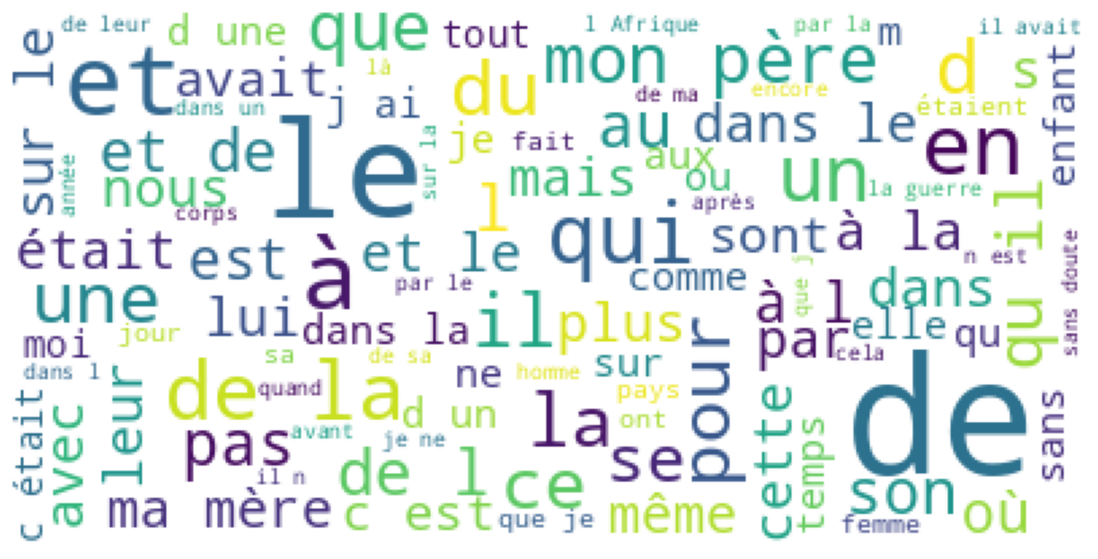



####################################################################################################




In [37]:
french_results = pipeline1.execute_pipeline("nlp_pipeline")

Let us analyze some of the outputs:

- create_corpus: We identified 27906 tokens and 5099 unique tokens in the French corpus. 
- show_most_common_words: The most common words are pronouns, punctuations, attributes, and prepositions, part of stop words. As we specified in the previous sections, they are part of the translation and cannot be removed from the sentences.
- plot_frequency_histogram: The token appearing the fewest number of times has a frequency of **57**, which is not a small number. We have no tokens appearing only one time, which is well new.
- plot_wordcloud: According to the WordCloud, the most common words in the corpus except the stop words are the most important words (defining the context of the text) in the corpus, which are words like: "père", "mère", "moi", "pays", "corps", "année", "Afrique".

Let us recuperate the different results.

In [38]:
tokens, (corpus, corpus_text), (freqs, token_idx) = french_results

The token indices will be used for the machine translation task. Let us show some of them.

In [39]:
pd.Series(token_idx).sample(20)


1729          dotées
1440    paraissaient
434             doit
563        affection
238           avions
1455          mètres
4538      cérémonies
3227          vastes
3040       emboîtées
2022        chercher
16               pas
1227        surmonté
3522         appelle
584        couchette
208             tôle
3951         artères
68             étais
2052       elle-même
151               si
297       cicatrices
dtype: object

- Wolof corpus: Let us apply the French pipeline to it

In [40]:
# modify the text
pipeline1.corpus = corpora['wolof_corpus'].to_list()

Let us execute the pipeline and investigate the results.

Method 1: tokenize_text -> result = True



####################################################################################################


Method 2: create_corpus -> result = True



100%|██████████| 149/149 [00:00<?, ?it/s]

Number of words: -----------29132
Number of unique words: ------------4408


####################################################################################################


Method 3: create_frequency -> result = False

    index  frequency
0   Doomu          2
1       -        474
2  aadama         19
3      bu        202
4       ,       2114


####################################################################################################


Method 4: show_frequency_out_limits -> result = False

Low limit: -------------2.0
High limit: -------------6.0


####################################################################################################


Method 5: show_most_common_words -> result = False

Most common words are:
(',', '.', 'ci', '-', 'a', 'ni', 'ak', 'mu', 'ba', 'ko', 'di', 'ma', 'yi', 'la', 'bi', 'yu', 'na', 'ñu', 'bu', 'daan')


####################################################################################################


Method 6: plot_frequency_hi



####################################################################################################


Method 7: recuperate_results -> result = True

The recuperate results method recuperates the last version of the frequency data frame as a freqDist. Make sure to add transformations before calling this method!


####################################################################################################


Method 8: plot_wordcloud -> result = False



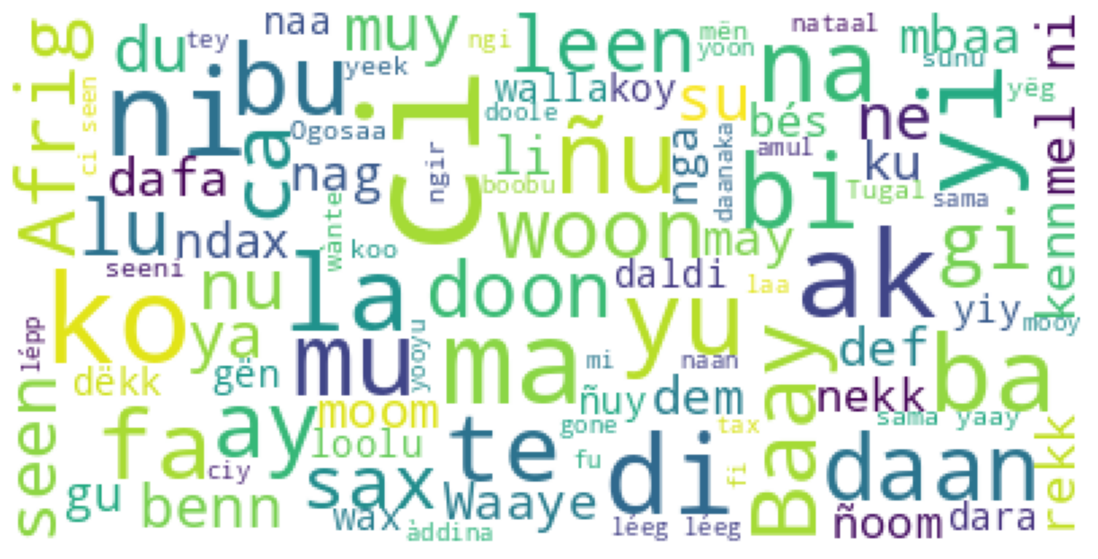



####################################################################################################




In [41]:
wolof_results = pipeline1.execute_pipeline("nlp_pipeline")